# Studio Embedding

In [1]:
emb_file = 'output/val_embeddings/val_all_merged.npz'

In [1]:
from model_analysis import plot_embeddings_umap

plot_embeddings_umap(
    'output/val_embeddings/val_all_merged.npz',
    color_by='labels',
    output_path='output/val_embeddings/val_umap_labels.png',
    show=False
)


Impossibile caricare la libreria torch dynamo


/home/isac/miniconda3/envs/videomae/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


UMAP embeddings (N=2400, dim=1408)
Salvato plot in: output/val_embeddings/val_umap_labels.png


/home/isac/miniconda3/envs/videomae/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


'UMAP embeddings 3D (N=2400, dim=1408)'

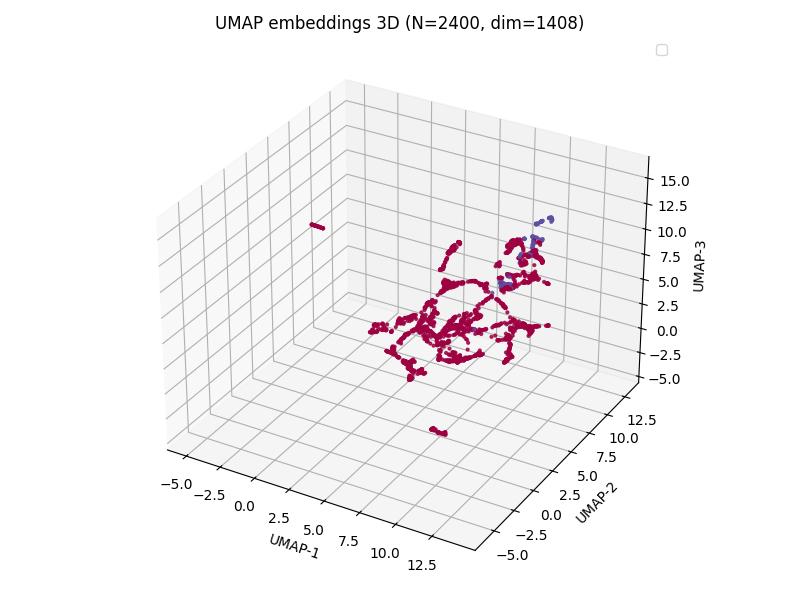

In [4]:
%matplotlib widget

import numpy as np
import umap
import matplotlib.pyplot as plt

d = np.load(emb_file, allow_pickle=True)
X = d['embeddings']
labels = d['labels'] if 'labels' in d else None
preds  = d['preds']  if 'preds'  in d else None

# Choose coloring
color = labels if labels is not None else (preds if preds is not None else None)

reducer = umap.UMAP(n_components=3, random_state=42, n_neighbors=15, min_dist=0.1, metric='euclidean')
Z = reducer.fit_transform(X)  # shape (N, 3)

N, D = X.shape
title = f"UMAP embeddings 3D (N={N}, dim={D})"

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(Z[:, 0], Z[:, 1], Z[:, 2],
                c=color if color is not None else 'tab:blue',
                s=4, cmap='Spectral', alpha=0.8)
#if color is not None:
#    cbar = fig.colorbar(sc, ax=ax, pad=0.1)
#    cbar.set_label('labels' if labels is not None else 'preds')

ax.set_title(title)
ax.set_xlabel('UMAP-1'); ax.set_ylabel('UMAP-2'); ax.set_zlabel('UMAP-3')
plt.legend()
plt.tight_layout()
plt.savefig('output/val_embeddings/val_umap3d_labels.png', dpi=200)

title


# UMAP + HDBSCAN

In [3]:
# Import dei pacchetti necessari
import numpy as np
import matplotlib.pyplot as plt

# Import di UMAP e HDBSCAN (versione CPU)
import umap
import hdbscan

# 1. Caricamento del file `.npz` contenente l'array di embedding
data = np.load(emb_file)           # Carica il file .npz
embeddings = data['embeddings']            # Estrae l'array con chiave "embeddings"
print("Shape degli embedding caricati:", embeddings.shape)  # Esempio: (2400, 1400)

# 2. Riduzione della dimensionalità usando UMAP (CPU)
umap_model = umap.UMAP(
    n_components=30,       # Riduciamo a 2D per visualizzazione
    n_neighbors=15,       # Numero di vicini per costruire il grafo
    min_dist=0.1,         # Distanza minima tra i punti nel nuovo spazio
    random_state=None,
    n_jobs=-1  
)
embedding_reduced = umap_model.fit_transform(embeddings)
# embedding_2d ha shape (2400, 2)

# 3. Clustering non supervisionato con HDBSCAN (CPU)
clusterer = hdbscan.HDBSCAN(
    min_cluster_size=15,  # dimensione minima del cluster (parametro da tarare)
    metric='euclidean',   # distanza usata
    cluster_selection_method='eom'
)
cluster_labels = clusterer.fit_predict(embedding_reduced)
# cluster_labels contiene le etichette di cluster (-1 indica rumore)

# Informazioni sul risultato del clustering
unique_labels = np.unique(cluster_labels)
n_clusters = (unique_labels != -1).sum()
n_noise = np.count_nonzero(cluster_labels == -1)
print(f"Numero di cluster trovati: {n_clusters}")
print(f"Punti considerati rumore: {n_noise}")


Shape degli embedding caricati: (2400, 1408)
Numero di cluster trovati: 25
Punti considerati rumore: 199


/home/isac/miniconda3/envs/videomae/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/isac/miniconda3/envs/videomae/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [9]:
# === Riduzione finale a 2D SOLO per visualizzazione ===
umap_vis = umap.UMAP(
    n_components=2,
    n_neighbors=15,
    min_dist=0.1,
    random_state=42
)
embedding_2d_vis = umap_vis.fit_transform(embedding_reduced)


/home/isac/miniconda3/envs/videomae/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


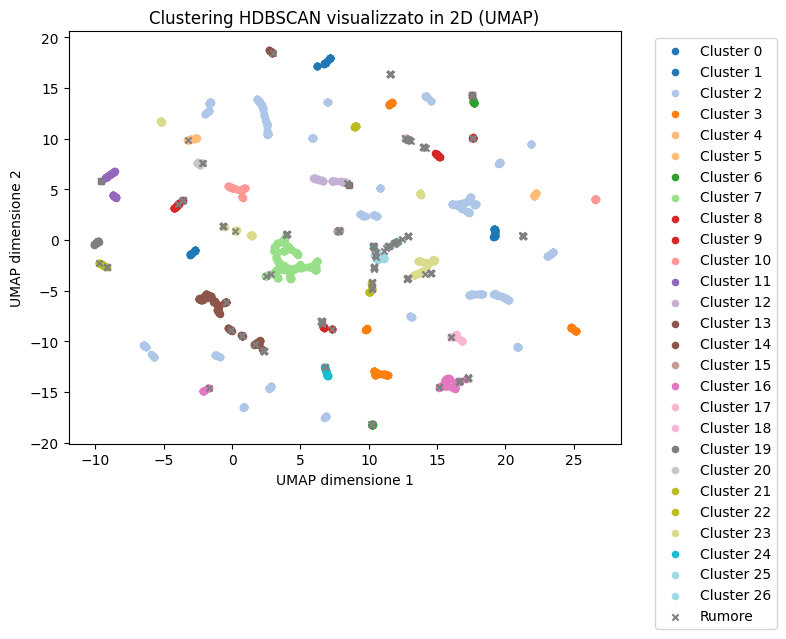

In [10]:

# Visualizzazione dei cluster trovati
plt.figure(figsize=(8, 6))

cluster_ids = [label for label in np.unique(cluster_labels) if label != -1]
cmap = plt.get_cmap('tab20', len(cluster_ids))

for idx, cluster_id in enumerate(cluster_ids):
    points = embedding_2d_vis[cluster_labels == cluster_id]
    plt.scatter(points[:, 0], points[:, 1],
                color=cmap(idx), label=f"Cluster {cluster_id}", s=20)

# Rumore (label = -1)
noise_points = embedding_2d_vis[cluster_labels == -1]
if len(noise_points) > 0:
    plt.scatter(noise_points[:, 0], noise_points[:, 1],
                color='gray', label="Rumore", s=20, marker='x')

plt.title("Clustering HDBSCAN visualizzato in 2D (UMAP)")
plt.xlabel("UMAP dimensione 1")
plt.ylabel("UMAP dimensione 2")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


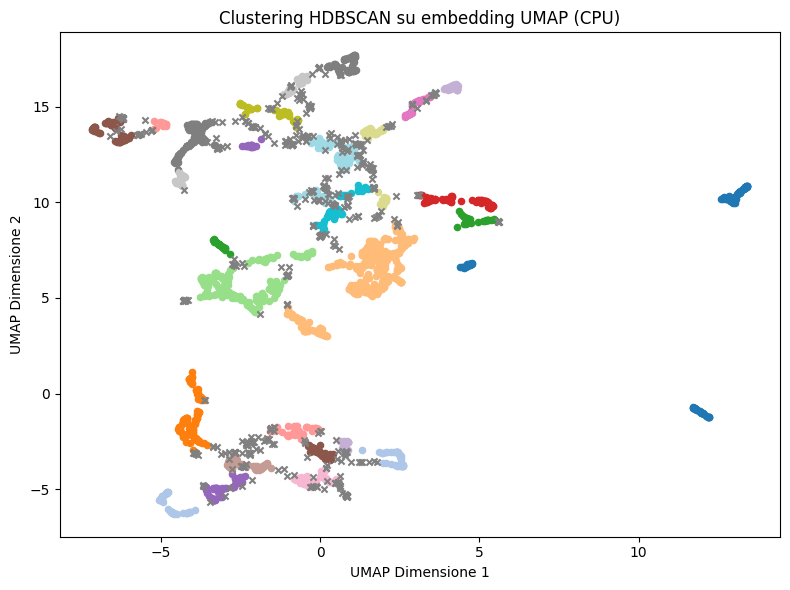

In [5]:

# 4. Visualizzazione dei risultati in 2D
plt.figure(figsize=(8, 6))

cluster_ids = [label for label in unique_labels if label != -1]
cmap = plt.get_cmap('tab20', len(cluster_ids))

# Plot di ogni cluster con colore differente
for idx, cluster_id in enumerate(cluster_ids):
    points = embedding_2d[cluster_labels == cluster_id]
    plt.scatter(points[:, 0], points[:, 1],
                color=cmap(idx), label=f"Cluster {cluster_id}", s=20)

# Plot dei punti considerati rumore
if n_noise > 0:
    noise_points = embedding_2d[cluster_labels == -1]
    plt.scatter(noise_points[:, 0], noise_points[:, 1],
                color='gray', label="Rumore", s=20, marker='x')

plt.title("Clustering HDBSCAN su embedding UMAP (CPU)")
plt.xlabel("UMAP Dimensione 1")
plt.ylabel("UMAP Dimensione 2")
#plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [4]:
import numpy as np
from sklearn.metrics import pairwise_distances

def get_medoids(X, labels, metric='euclidean'):
    """
    Restituisce l'indice del medoide per ciascun cluster.
    
    Params
    ------
    X : array (n_samples, n_features)
        Dati su cui è stato fatto il clustering (es. embedding ridotti)
    labels : array (n_samples,)
        Etichette dei cluster (-1 = rumore)
    metric : str
        Metrica di distanza (default: euclidean)

    Returns
    -------
    dict: cluster_id -> indice nel dataset originale
    """
    medoids = {}
    for cluster_id in np.unique(labels):
        if cluster_id == -1:
            continue  # salta il rumore
        # prendi i punti di quel cluster
        idx = np.where(labels == cluster_id)[0]
        cluster_points = X[idx]

        # calcola tutte le distanze intra-cluster
        D = pairwise_distances(cluster_points, metric=metric)

        # per ogni punto somma le distanze agli altri
        sum_dist = D.sum(axis=1)

        # trova il punto con distanza media minima
        medoid_local_idx = np.argmin(sum_dist)

        # indice globale nel dataset
        medoids[cluster_id] = idx[medoid_local_idx]

    return medoids


In [5]:

# Esempio d'uso:
medoids = get_medoids(embedding_reduced, cluster_labels)
print(medoids)  # dizionario {id_cluster: indice}


{0: 1510, 1: 47, 2: 644, 3: 2150, 4: 1350, 5: 1512, 6: 670, 7: 744, 8: 394, 9: 1634, 10: 2035, 11: 478, 12: 363, 13: 400, 14: 165, 15: 507, 16: 2178, 17: 977, 18: 658, 19: 687, 20: 1312, 21: 87, 22: 1438, 23: 735, 24: 726}


In [ ]:
bbb

In [22]:
import numpy as np
import pandas as pd
import umap
import hdbscan
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score

import warnings
warnings.filterwarnings('ignore')

def evaluate_clustering_vs_dims(
    embeddings: np.ndarray,
    dims=(5,10,15,20,30,50),
    y_true: np.ndarray  = None,
    pca_components: int = 100,
    umap_kwargs: dict = None,
    hdbscan_kwargs: dict = None,
    random_state: int = None
) -> pd.DataFrame:
    """
    Sweep su più dimensioni target per UMAP e valutazione HDBSCAN.
    Ritorna un DataFrame con metriche interne ed esterne (se y_true fornito).

    Params
    ------
    embeddings : array (n_samples, n_features)   # es. (2400, 1400)
    dims : iterable di int                       # dimensioni UMAP per il clustering
    y_true : array opzionale con etichette reali (per ARI/NMI, esclusi i punti rumore)
    pca_components : int                         # PCA preliminare per velocizzare/stabilizzare
    umap_kwargs : dict                           # override di default UMAP
    hdbscan_kwargs : dict                        # override di default HDBSCAN
    random_state : int|None                      # seed per riproducibilità; None = più parallelo/varianza

    Returns
    -------
    pd.DataFrame con colonne:
      ['dim', 'n_clusters', 'noise_frac', 'silhouette', 'davies_bouldin',
       'calinski_harabasz', 'avg_cluster_size', 'median_cluster_size',
       'ARI', 'NMI']
    """
    if umap_kwargs is None:
        umap_kwargs = dict(n_neighbors=15, min_dist=0.1, metric="euclidean", random_state=random_state)
    if hdbscan_kwargs is None:
        hdbscan_kwargs = dict(min_cluster_size=15, metric='euclidean', cluster_selection_method='eom')

    # PCA preliminare (veloce e spesso benefica)
    pca = PCA(n_components=min(pca_components, embeddings.shape[1]), random_state=random_state)
    X_pca = pca.fit_transform(embeddings)

    rows = []
    for d in dims:
        # 1) UMAP alla dimensione d (per clustering)
        umap_model = umap.UMAP(n_components=d, **umap_kwargs)
        X_d = umap_model.fit_transform(X_pca)

        # 2) HDBSCAN sullo spazio ridotto
        clusterer = hdbscan.HDBSCAN(**hdbscan_kwargs)
        labels = clusterer.fit_predict(X_d)  # -1 = rumore

        # indicatori base
        unique = np.unique(labels)
        cluster_ids = [c for c in unique if c != -1]
        n_clusters = len(cluster_ids)
        noise_frac = float(np.mean(labels == -1))

        # distribuzione dimensioni cluster
        cluster_sizes = [np.sum(labels == c) for c in cluster_ids]
        avg_cs = float(np.mean(cluster_sizes)) if cluster_sizes else 0.0
        med_cs = float(np.median(cluster_sizes)) if cluster_sizes else 0.0

        # 3) Metriche interne (richiedono >=2 cluster "validi")
        if n_clusters >= 2:
            # Silhouette sui soli punti non-rumore
            mask = labels != -1
            try:
                sil = silhouette_score(X_d[mask], labels[mask], metric='euclidean') if np.sum(mask) > 1 else np.nan
            except Exception:
                sil = np.nan

            # DB/CH su tutti i punti assegnati a cluster (esclude rumore)
            try:
                db = davies_bouldin_score(X_d[mask], labels[mask]) if np.sum(mask) > 1 else np.nan
            except Exception:
                db = np.nan
            try:
                ch = calinski_harabasz_score(X_d[mask], labels[mask]) if np.sum(mask) > 1 else np.nan
            except Exception:
                ch = np.nan
        else:
            sil = np.nan
            db = np.nan
            ch = np.nan

        # 4) Metriche esterne (opzionali): ARI/NMI su subset non-rumore
        ARI = np.nan
        NMI = np.nan
        if y_true is not None:
            mask = labels != -1
            if mask.any() and len(np.unique(labels[mask])) >= 2 and len(np.unique(y_true[mask])) >= 2:
                try:
                    ARI = adjusted_rand_score(y_true[mask], labels[mask])
                    NMI = normalized_mutual_info_score(y_true[mask], labels[mask])
                except Exception:
                    ARI = np.nan
                    NMI = np.nan

        rows.append(dict(
            dim=d,
            n_clusters=n_clusters,
            noise_frac=noise_frac,
            silhouette=sil,
            davies_bouldin=db,
            calinski_harabasz=ch,
            avg_cluster_size=avg_cs,
            median_cluster_size=med_cs,
            ARI=ARI,
            NMI=NMI
        ))

    return pd.DataFrame(rows).sort_values('dim').reset_index(drop=True)


In [18]:
import pandas as pd
import numpy as np

def repeat_clustering_evaluation(
    embeddings: np.ndarray,
    dims=(5,10,15,20,30,50),
    n_repeats: int = 5,
    #seeds: list[int|None] | None = None,
    **kwargs
) -> pd.DataFrame:
    """
    Ripete evaluate_clustering_vs_dims più volte con seed diversi
    e concatena i risultati in un unico DataFrame.

    Params
    ------
    embeddings : array (n_samples, n_features)
    dims : iterable di int (dimensioni target per UMAP)
    n_repeats : quante ripetizioni fare
    seeds : lista di seed (se None, genera automaticamente)
    kwargs : parametri aggiuntivi passati a evaluate_clustering_vs_dims

    Returns
    -------
    DataFrame con colonne originali + 'repeat' e 'seed'
    """
    #if seeds is None:
        # se vuoi includere run "non deterministici", metti alcuni None
    #    seeds = [None if i==0 else np.random.randint(0, 10_000) for i in range(n_repeats)]
    #elif len(seeds) < n_repeats:
    #    raise ValueError("La lista seeds è più corta di n_repeats")

    all_runs = []
    for i in range(n_repeats):
        #seed = seeds[i]
        df = evaluate_clustering_vs_dims(
            embeddings,
            dims=dims,
            random_state=None,
            **kwargs
        )
        df['repeat'] = i
        #df['seed'] = seed
        all_runs.append(df)

    return pd.concat(all_runs, ignore_index=True)


In [23]:
# Fai 5 ripetizioni con seed diversi
lista_dim = range(5, 50, 3)
results_multi = repeat_clustering_evaluation(
    embeddings,
    dims=lista_dim,
    n_repeats=1,
    pca_components=100,
    hdbscan_kwargs=dict(min_cluster_size=15)
)

# Media e deviazione standard per ogni dimensione
summary = results_multi.groupby('dim').agg(['mean','std'])
print(summary[['silhouette','davies_bouldin','calinski_harabasz','n_clusters','noise_frac']])


    silhouette     davies_bouldin     calinski_harabasz     n_clusters      \
          mean std           mean std              mean std       mean std   
dim                                                                          
5     0.564980 NaN       0.503310 NaN       4433.513827 NaN       34.0 NaN   
8     0.588786 NaN       0.480687 NaN       1906.676083 NaN       26.0 NaN   
11    0.586508 NaN       0.486251 NaN       4820.425321 NaN       39.0 NaN   
14    0.549953 NaN       0.536102 NaN       4708.293475 NaN       35.0 NaN   
17    0.573110 NaN       0.479156 NaN       4523.670285 NaN       39.0 NaN   
20    0.563701 NaN       0.487205 NaN       4585.297631 NaN       38.0 NaN   
23    0.615518 NaN       0.482666 NaN       1725.788119 NaN       30.0 NaN   
26    0.614744 NaN       0.489796 NaN       1618.710631 NaN       32.0 NaN   
29    0.596407 NaN       0.528263 NaN       1663.290416 NaN       31.0 NaN   
32    0.605700 NaN       0.510148 NaN       2064.055015 NaN     

In [28]:
import matplotlib.pyplot as plt

def plot_clustering_metrics(results_df):
    """
    Plotta silhouette, Davies-Bouldin e Calinski-Harabasz
    al variare della dimensione ridotta.
    """
    dims = results_df['dim']

    plt.figure(figsize=(14, 4))

    # --- Silhouette ---
    plt.subplot(1, 3, 1)
    plt.plot(dims, results_df['silhouette'], marker='o')
    plt.xlabel("Dimensioni UMAP")
    plt.ylabel("Silhouette score")
    plt.title("Silhouette (↑ meglio)")
    plt.grid(True)

    # --- Davies-Bouldin ---
    plt.subplot(1, 3, 2)
    plt.plot(dims, results_df['davies_bouldin'], marker='o', color='orange')
    plt.xlabel("Dimensioni UMAP")
    plt.ylabel("Davies-Bouldin")
    plt.title("Davies-Bouldin (↓ meglio)")
    plt.grid(True)

    # --- Calinski-Harabasz ---
    plt.subplot(1, 3, 3)
    plt.plot(dims, results_df['calinski_harabasz'], marker='o', color='green')
    plt.xlabel("Dimensioni UMAP")
    plt.ylabel("Calinski-Harabasz")
    plt.title("Calinski-Harabasz (↑ meglio)")
    plt.grid(True)

    plt.tight_layout()
    plt.show()

def plot_cluster_stats(results_df):
    """
    Plotta il numero di cluster trovati e la frazione di rumore
    al variare della dimensione ridotta.
    """
    dims = results_df['dim']

    fig, ax1 = plt.subplots(figsize=(8, 5))

    color1 = 'tab:blue'
    ax1.set_xlabel("Dimensioni UMAP")
    ax1.set_ylabel("Numero cluster", color=color1)
    ax1.plot(dims, results_df['n_clusters'], marker='o', color=color1, label="N. cluster")
    ax1.tick_params(axis='y', labelcolor=color1)
    ax1.grid(True)

    # Secondo asse Y per noise_frac
    ax2 = ax1.twinx()
    color2 = 'tab:red'
    ax2.set_ylabel("Frazione rumore", color=color2)
    ax2.plot(dims, results_df['noise_frac'], marker='s', color=color2, label="Rumore")
    ax2.tick_params(axis='y', labelcolor=color2)

    plt.title("Evoluzione cluster e rumore vs dimensioni UMAP")
    fig.tight_layout()
    plt.show()

import matplotlib.pyplot as plt

def plot_metrics_with_errorbars(results_multi, metrics=('silhouette','davies_bouldin','calinski_harabasz')):
    """
    Plotta metriche con media ± deviazione standard su più ripetizioni.
    results_multi: DataFrame con colonne ['dim', 'repeat', metriche...]
    metrics: lista di metriche da plottare
    """
    grouped = results_multi.groupby('dim')

    plt.figure(figsize=(15, 4))

    for i, metric in enumerate(metrics, start=1):
        means = grouped[metric].mean()
        stds = grouped[metric].std()

        plt.subplot(1, len(metrics), i)
        plt.errorbar(means.index, means.values, yerr=stds.values, fmt='-o', capsize=5)
        plt.xlabel("Dimensioni UMAP")
        plt.ylabel(metric)
        if metric == 'silhouette':
            plt.title("Silhouette (↑ meglio)")
        elif metric == 'davies_bouldin':
            plt.title("Davies-Bouldin (↓ meglio)")
        elif metric == 'calinski_harabasz':
            plt.title("Calinski-Harabasz (↑ meglio)")
        else:
            plt.title(metric)
        plt.grid(True)

    plt.tight_layout()
    plt.savefig("metrics_clustering.png")
    plt.show()

def plot_cluster_stats_with_errorbars(results_multi):
    """
    Plotta media ± std del numero di cluster e della frazione di rumore
    al variare delle dimensioni UMAP.
    """
    grouped = results_multi.groupby('dim')

    means_clusters = grouped['n_clusters'].mean()
    stds_clusters = grouped['n_clusters'].std()

    means_noise = grouped['noise_frac'].mean()
    stds_noise = grouped['noise_frac'].std()

    fig, ax1 = plt.subplots(figsize=(8, 5))

    # Numero cluster (asse sinistro)
    color1 = 'tab:blue'
    ax1.errorbar(means_clusters.index, means_clusters.values,
                 yerr=stds_clusters.values, fmt='-o', capsize=5,
                 color=color1, label="N. cluster")
    ax1.set_xlabel("Dimensioni UMAP")
    ax1.set_ylabel("Numero cluster", color=color1)
    ax1.tick_params(axis='y', labelcolor=color1)
    ax1.grid(True)

    # Frazione rumore (asse destro)
    ax2 = ax1.twinx()
    color2 = 'tab:red'
    ax2.errorbar(means_noise.index, means_noise.values,
                 yerr=stds_noise.values, fmt='-s', capsize=5,
                 color=color2, label="Rumore")
    ax2.set_ylabel("Frazione rumore", color=color2)
    ax2.tick_params(axis='y', labelcolor=color2)

    plt.title("Cluster e rumore (media ± std su ripetizioni)")
    fig.tight_layout()
    plt.savefig("num_clusters.png")
    plt.show()


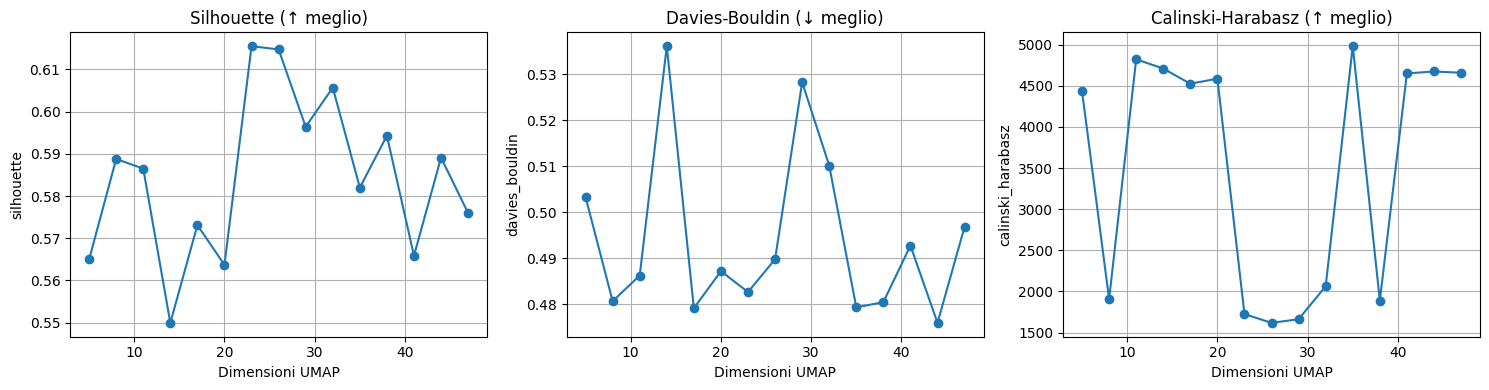

In [29]:
plot_metrics_with_errorbars(results_multi)

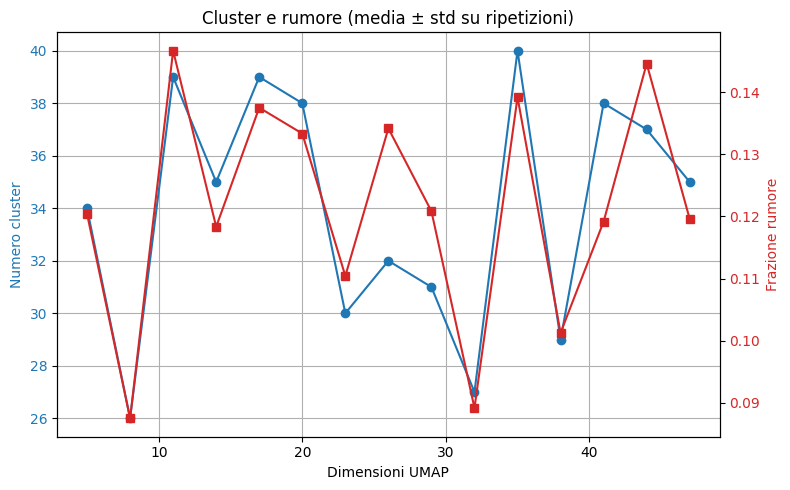

In [30]:
plot_cluster_stats_with_errorbars(results_multi)
